# Combatting Partisan Homogenization in New Content Recommenders - Baselines(BERT)

In [1]:
# to do
# test with our prototypes and our actual topic labelled data
# use immigration and guns topic, prototypes have to have differing stance variation

## Table of Contents 
### [Clustering Documents, Filtering and Vectorization](#Clustering_Documents_Filtering_Vectorization)
### [Baseline 1 - (Cluster Similarity vs Model Performance)](#Cluster_Similarity_vs_Model_Performance)
### [Baseline 2 - (Online Setting Performance)](#Online_Setting_Performance)
### [Baseline 3 - (Single Cluster Online Setting Performance)](#Single_Cluster_Online_Setting_Performance)
### [Baseline 4 - (Regularization vs Online Setting Performance)](#Regularization_vs_Online_Setting_Performance)
### [Baseline 5 - (Learning Rate vs Online Setting Performance)](#Learning_Rate_vs_Online_Setting_Performance)
### [Baseline 6 - (Online Setting Mixed Data Performance)](#Online_Setting_Mixed_Data_Performance)
### [Baseline 7 - (Learning Rate vs Online Setting Mixed Data Performance)](#Learning_Rate_vs_Online_Setting_Mixed_Data_Performance)

#### Important:
* Heterogenous User:
    * Conservative on Cluster 1 but Liberal on Cluster 2
* Homogeneous User:
    * Conservative on Cluster 1 and Cluster 2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [4]:
from general_utils import timer

from config import RANDOM_SEED

from bert_utils import load_bert_output

from preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction

from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from data_utils import load_data, sample_data, balanced_sampling, create_train_test

from metrics_utils import calculate_avg_precision, calculate_map, get_scores, get_scores_wot, calculate_avg_precision_param_variation, calculate_map_param_variation

from model_utils import ( run_model, 
                         run_bs1_train_all, 
                         run_online_setting_active, 
                         run_bs2_train_all, 
                         run_bs3_train_all, 
                         run_bs4_train_all, 
                         run_bs5_train_all, 
                         run_bs6_train_all, 
                         run_bs7_train_all)

from plotters_baseline import ( plot_size_dist, 
                               bsl1_sim_vs_score_all_users, 
                               regularization_plot_helper, 
                               plot_regularization_vs_metrics_at_k, 
                               combine_scores_reg_vs_metrics_at_k, 
                               plot_regularization_vs_metrics_at_k_cumu, 
                               plot_lr_vs_metrics_at_k, 
                               plot_lr_vs_metrics_at_k_cumu, 
                               plot_online_setting_per_clusterpair, 
                               plot_helper_all_cp, 
                               plot_all_cp_online, 
                               plot_all_cp_singlecluster, 
                               plot_helper_scp, 
                               plot_single_cluster_performance, 
                               plot_mixed_data_all_cp_perf, 
                               plot_helper_md, 
                               plot_prec_sep, 
                               plot_mixed_data_performance_per_cluster, 
                               plot_mixed_data_performance, 
                               combine_scores_cumu_online_setting,
                               plot_mixed_cluster_cumulative, 
                               plot_online_learning_cumulative, 
                               plot_single_cluster_cumulative, 
                               plot_mixed_data_all_cp_perf, 
                               lr_mixed_plot_helper, 
                               plot_lr_vs_metrics_at_k_mixed, 
                               plot_mixed_data_all_cp_precis_lr, 
                               plot_mixed_cluster_cumulative_per_cluster  )   

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [5]:
warnings.filterwarnings('ignore')

In [6]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

# Main Components

1) Data Loading  
2) Sampling  
3) Text Preprocessing  
4) Vectorization  
5) Dimensionality Reductions  
6) Clustering  
7) Clustering Performance Check  
8) Cluster Filtering  
9) Pairwise Selection  
10) Model Training and Performance  
11) Pairwise score analysis  

## Clustering Documents, Filtering and Vectorization <a class="anchor" id="Clustering_Documents_Filtering_Vectorization"></a>

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text'],
      dtype='object')
Df original shape : (921037, 10)
Df shape after dropping nan text : (919430, 10)
Df shape after dropping duplicate articles based on title : (912084, 10)
Df shape after dropping 0 stance articles : (630425, 10)

Finished running 'load_data' in 0.4576 mins


Finished running 'sample_data' in 0.0018 mins

Sampled Size: 100000
Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces

Finished running 'preprocess_texts' in 0.3346 mins

First Ten Files : ['/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/0.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/1.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/2.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/3.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_ou

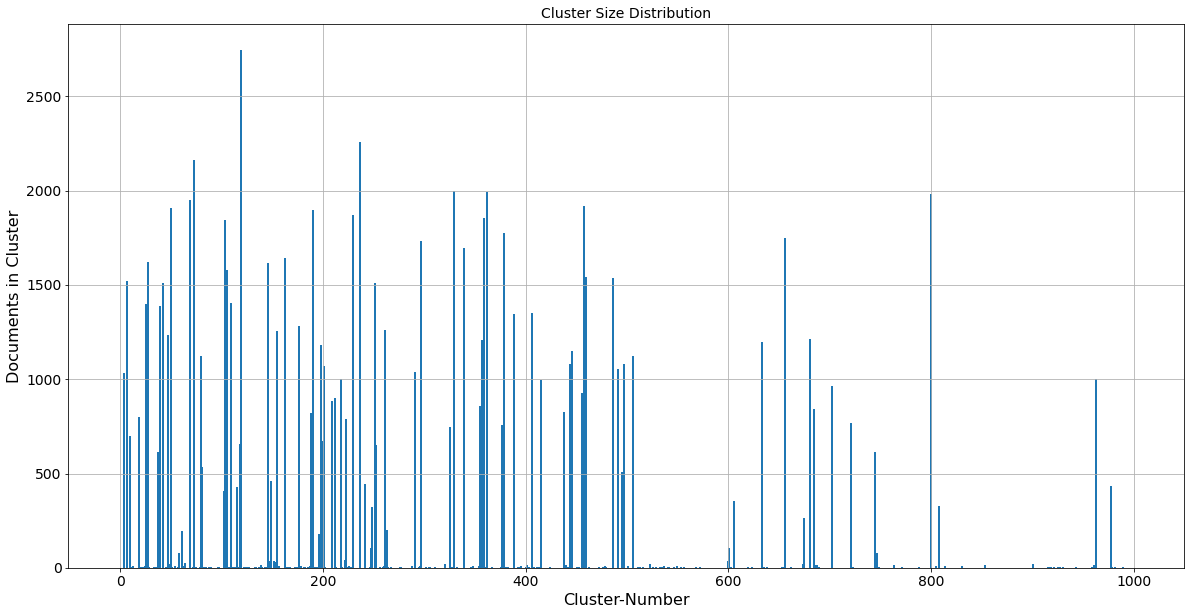


Finished running 'get_pairwise_dist' in 0.0002 mins


Number of Cluster Pairs : 499500

Finished running 'get_cluster_pairs' in 0.0006 mins

499500


In [7]:
path = "../articles.csv"

main_df = load_data(path)

sampled_df = sample_data(df=main_df,sample_size=100000,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])

reduced_vectors =  load_bert_output(folder1="/media/karthikshivaram/Extra_disk_1/Bert_model_outputs",
                              folder2="/media/karthikshivaram/Extra_Disk_2/Bert_model_outputs",
                              layer=11,aggregation="mean + max")

print("Bert Embedding Output Shape : %s" %str(reduced_vectors.shape))

clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans")

cluster_sizes = get_cluster_sizes(cluster_clf)

plot_size_dist(cluster_sizes)

cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")

cluster_pairs = get_cluster_pairs(num_clusters=1000)
print(len(cluster_pairs))

In [8]:
doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)


Finished running 'cluster2doc' in 0.0005 mins



In [9]:
filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=450,
                                        max_size=5000,
                                        min_partisan_size=0.4)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))


Finished running 'filter_clusters' in 0.1027 mins

Filtered CLustered Pairs : 820


In [10]:
top100 = get_top_100_clusterpairs(cluster_pairs=filtered_cluster_pairs,dist_matrix=cluster_pair_dist_mat,reverse=True)


Finished running 'get_top_100_clusterpairs' in 0.0000 mins



## Baseline 1 : <a class="anchor" id="Cluster_Similarity_vs_Model_Performance"></a>

In [11]:
df_result = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Heterogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.1910 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.3466 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.1083 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.1156 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.0958 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.1160 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.3564 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.1291 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.1509 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.3252 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.2212 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.1347 mins

Training model

In [12]:
df_result_homog = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Homogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.1425 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.3158 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.0999 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.1050 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.1263 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.1076 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.3263 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.1229 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.1298 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.3138 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.1764 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.1619 mins

Training model

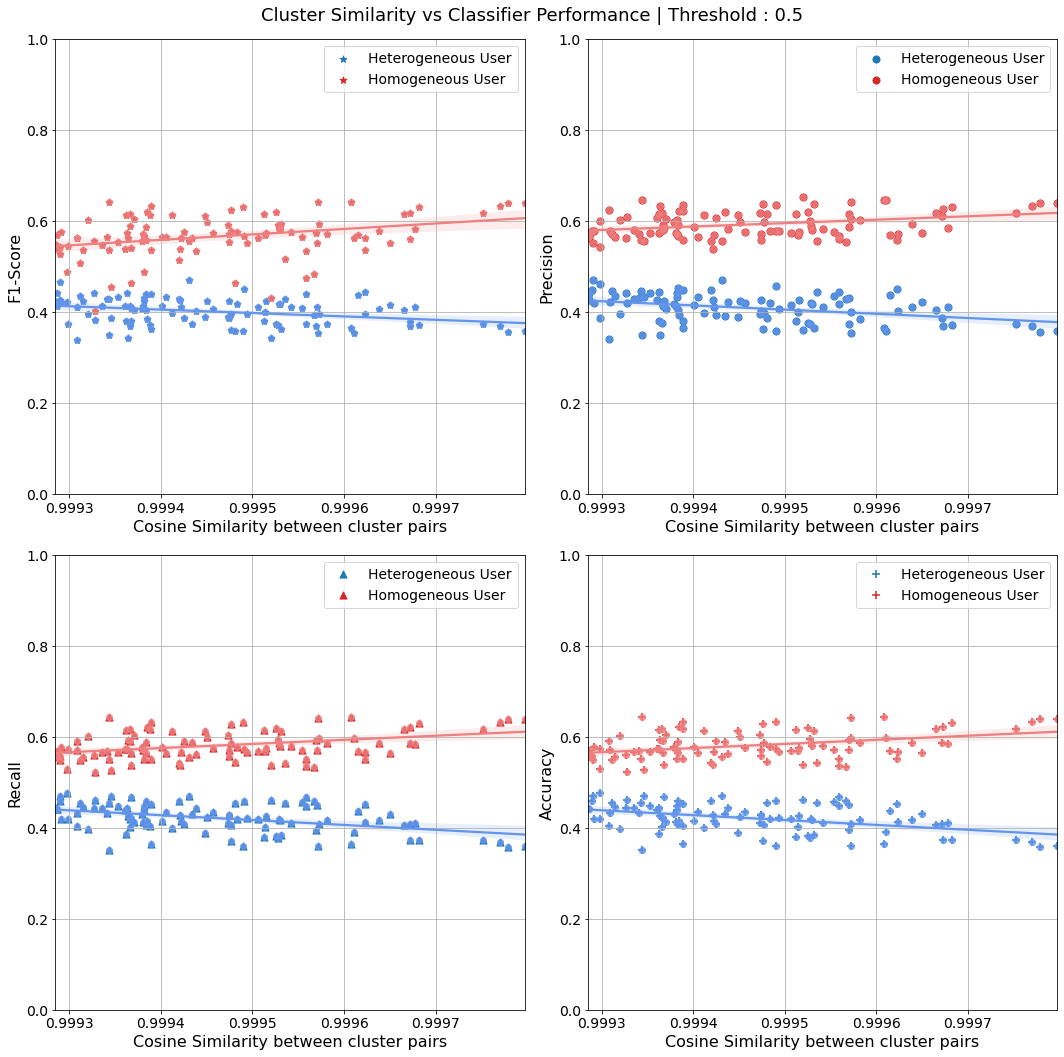


Finished running 'bsl1_sim_vs_score_all_users' in 0.0209 mins



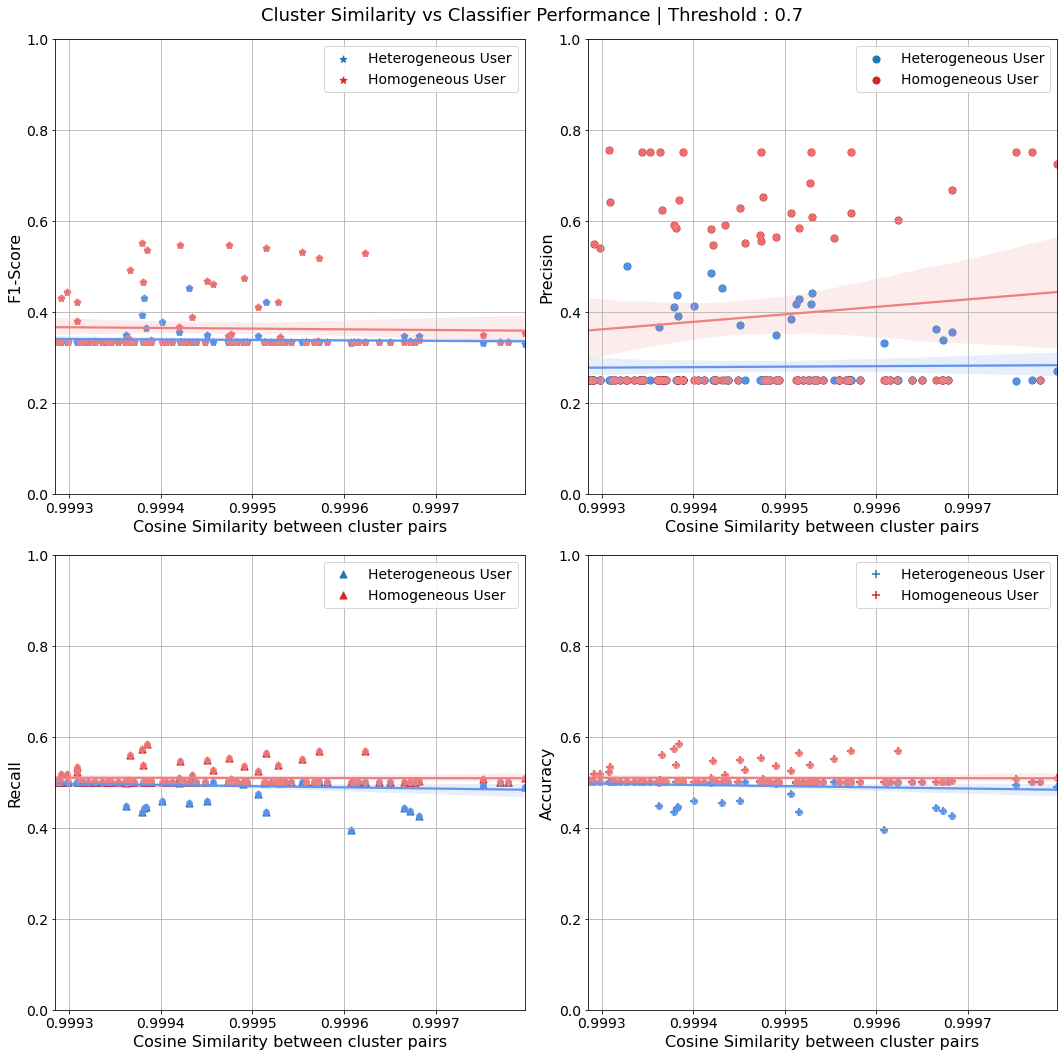


Finished running 'bsl1_sim_vs_score_all_users' in 0.0205 mins



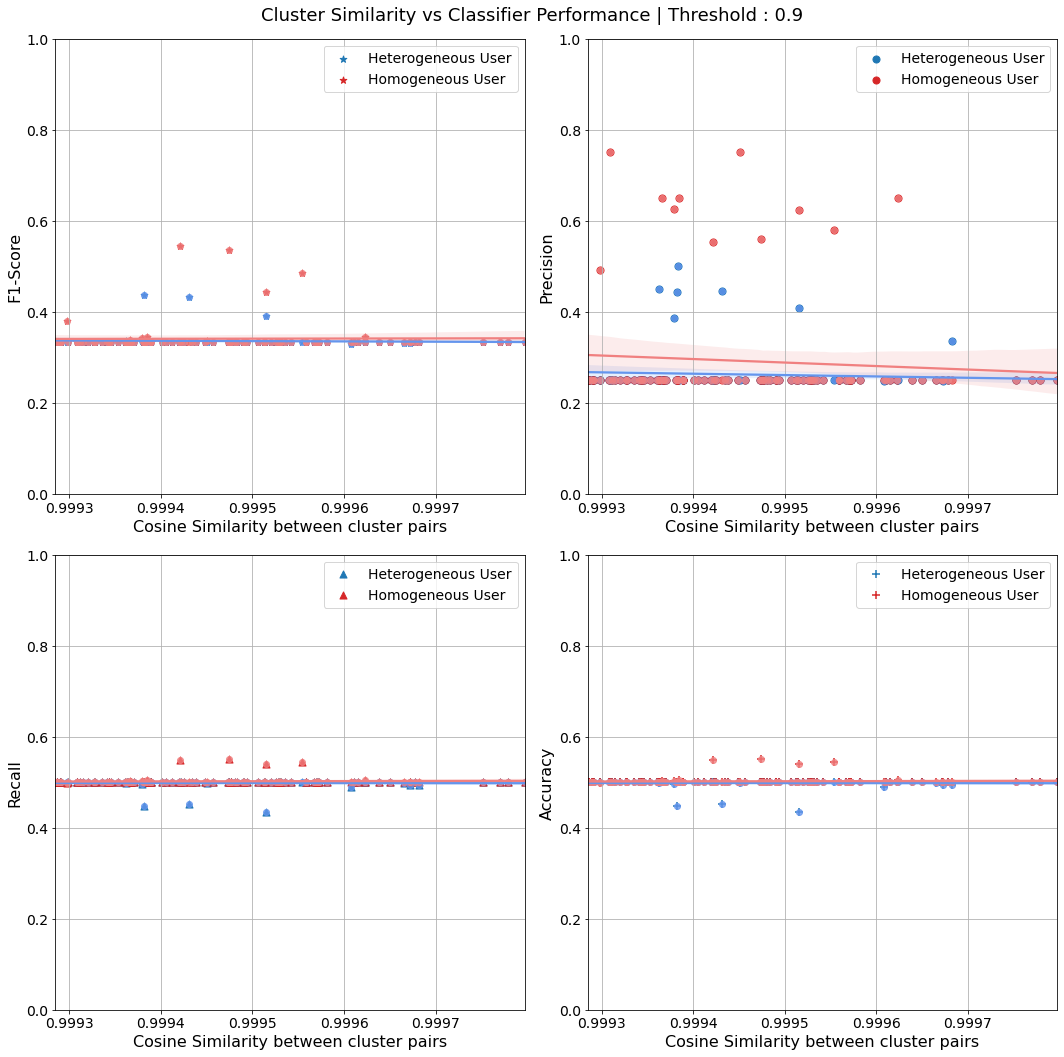


Finished running 'bsl1_sim_vs_score_all_users' in 0.0205 mins



In [13]:
for threshold in [0.5,0.7,0.9]:
    bsl1_sim_vs_score_all_users(df_results_hetero=df_result,
                                df_results_homo=df_result_homog,
                                threshold=threshold)

<!-- ## Online Learning Setting - Active Learning Setting (Performance Measured on Held Out Validation Dataset) -->

## Baseline 2 : <a class="anchor" id="Online_Setting_Performance"></a>

In [14]:
hetero_scores,df_res_map_hetero = run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : (7, 69)
Training model for cluster pair : (237, 329)
Training model for cluster pair : (109, 329)
Training model for cluster pair : (25, 237)
Training model for cluster pair : (25, 329)
Training model for cluster pair : (25, 109)
Training model for cluster pair : (163, 359)
Training model for cluster pair : (357, 656)
Training model for cluster pair : (251, 389)
Training model for cluster pair : (237, 486)
Training model for cluster pair : (486, 800)
Training model for cluster pair : (251, 656)
Training model for cluster pair : (69, 163)
Training model for cluster pair : (25, 486)
Training model for cluster pair : (357, 633)
Training model for cluster pair : (359, 389)
Training model for cluster pair : (251, 491)
Training model for cluster pair : (4, 291)
Training model for cluster pair : (359, 800)
Training model for cluster pair : (357, 415)
Training model for cluster pair : (69, 291)
Training model for cluster pair : (37, 415)
Training model for clu

In [15]:
homo_scores, df_res_map_homo =  run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : (7, 69)
Training model for cluster pair : (237, 329)
Training model for cluster pair : (109, 329)
Training model for cluster pair : (25, 237)
Training model for cluster pair : (25, 329)
Training model for cluster pair : (25, 109)
Training model for cluster pair : (163, 359)
Training model for cluster pair : (357, 656)
Training model for cluster pair : (251, 389)
Training model for cluster pair : (237, 486)
Training model for cluster pair : (486, 800)
Training model for cluster pair : (251, 656)
Training model for cluster pair : (69, 163)
Training model for cluster pair : (25, 486)
Training model for cluster pair : (357, 633)
Training model for cluster pair : (359, 389)
Training model for cluster pair : (251, 491)
Training model for cluster pair : (4, 291)
Training model for cluster pair : (359, 800)
Training model for cluster pair : (357, 415)
Training model for cluster pair : (69, 291)
Training model for cluster pair : (37, 415)
Training model for clu


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



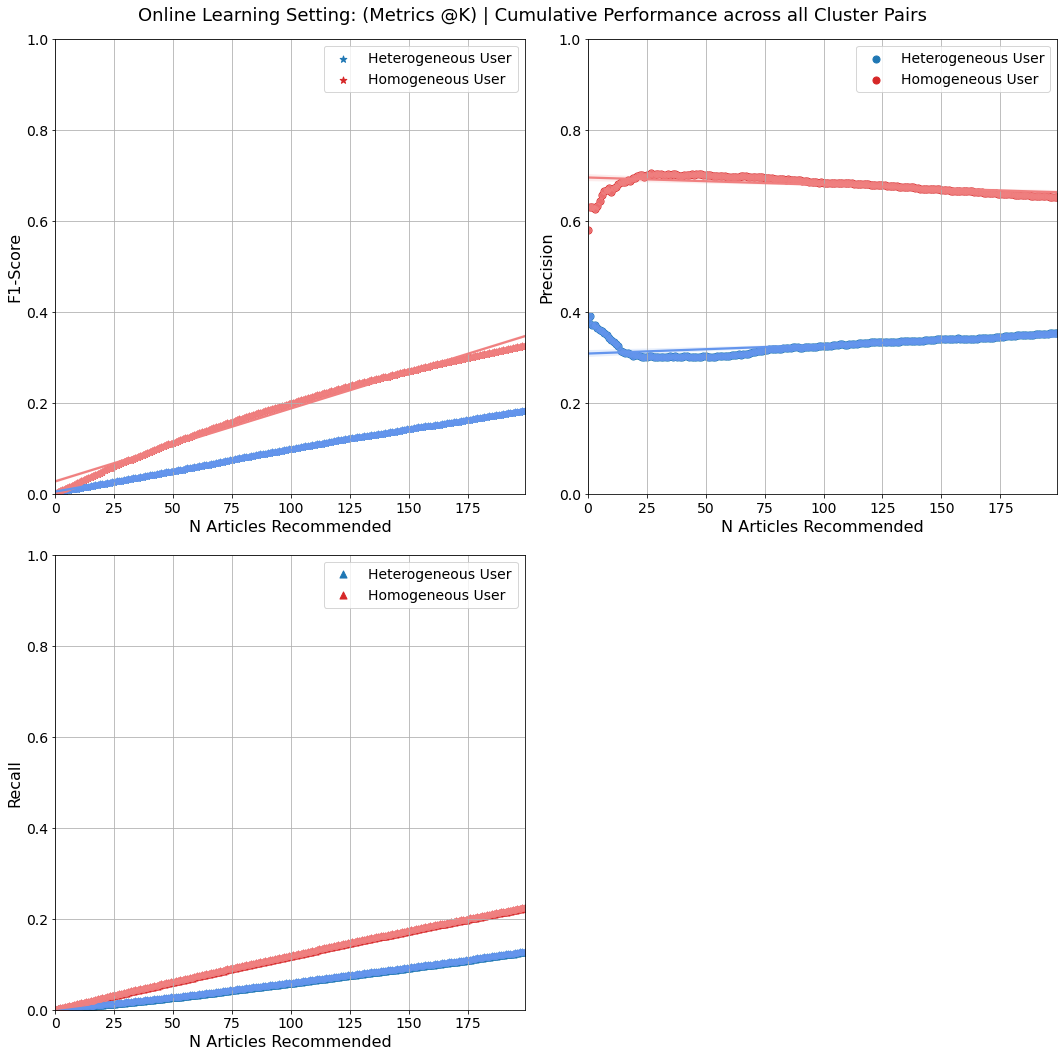


Finished running 'plot_online_setting_per_clusterpair' in 0.0189 mins


Finished running 'plot_online_learning_cumulative' in 0.0190 mins



In [16]:
plot_online_learning_cumulative(homo_scores,hetero_scores,active=False)

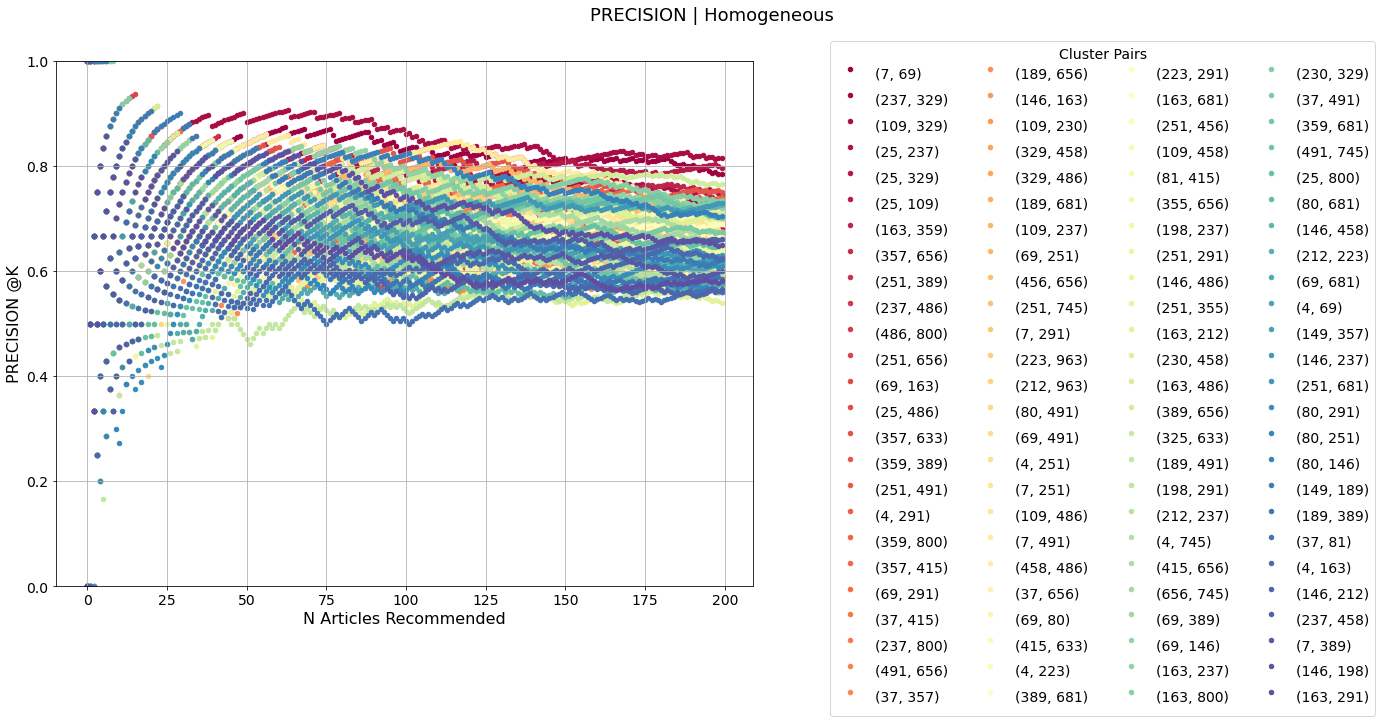


Finished running 'plot_all_cp_online' in 0.0646 mins



In [17]:
plot_all_cp_online(homo_scores,user_type="Homogeneous",metric="precision")

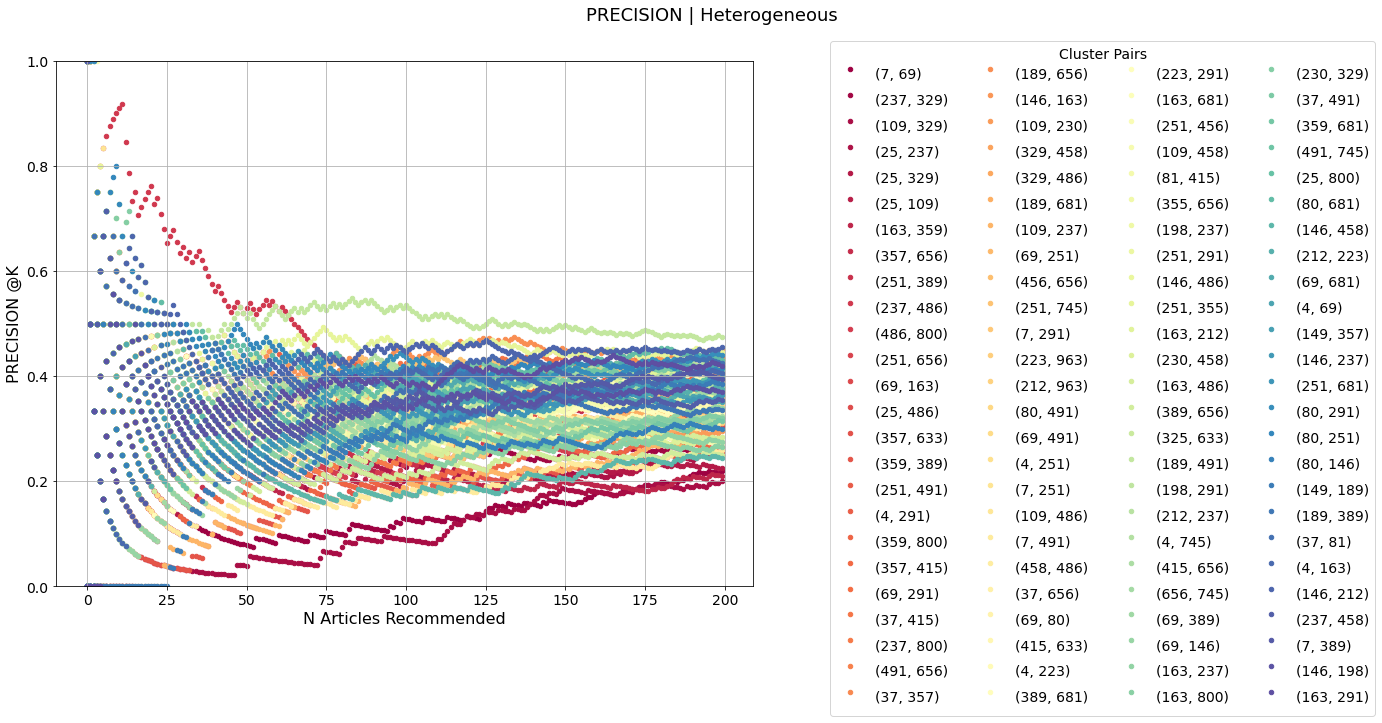


Finished running 'plot_all_cp_online' in 0.0636 mins



In [18]:
plot_all_cp_online(hetero_scores,user_type="Heterogeneous",metric="precision")

In [19]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [20]:
np.mean(avg_presc_homo)

0.6788751612804957

In [21]:
avg_presc_hetero = calculate_avg_precision(hetero_scores,mode="single")

In [22]:
np.mean(avg_presc_hetero)

0.3272809183938318

## Baseline 3 :  <a class="anchor" id="Single_Cluster_Online_Setting_Performance"></a>

In [23]:
hetero_scores = run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [24]:
homo_scores =  run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



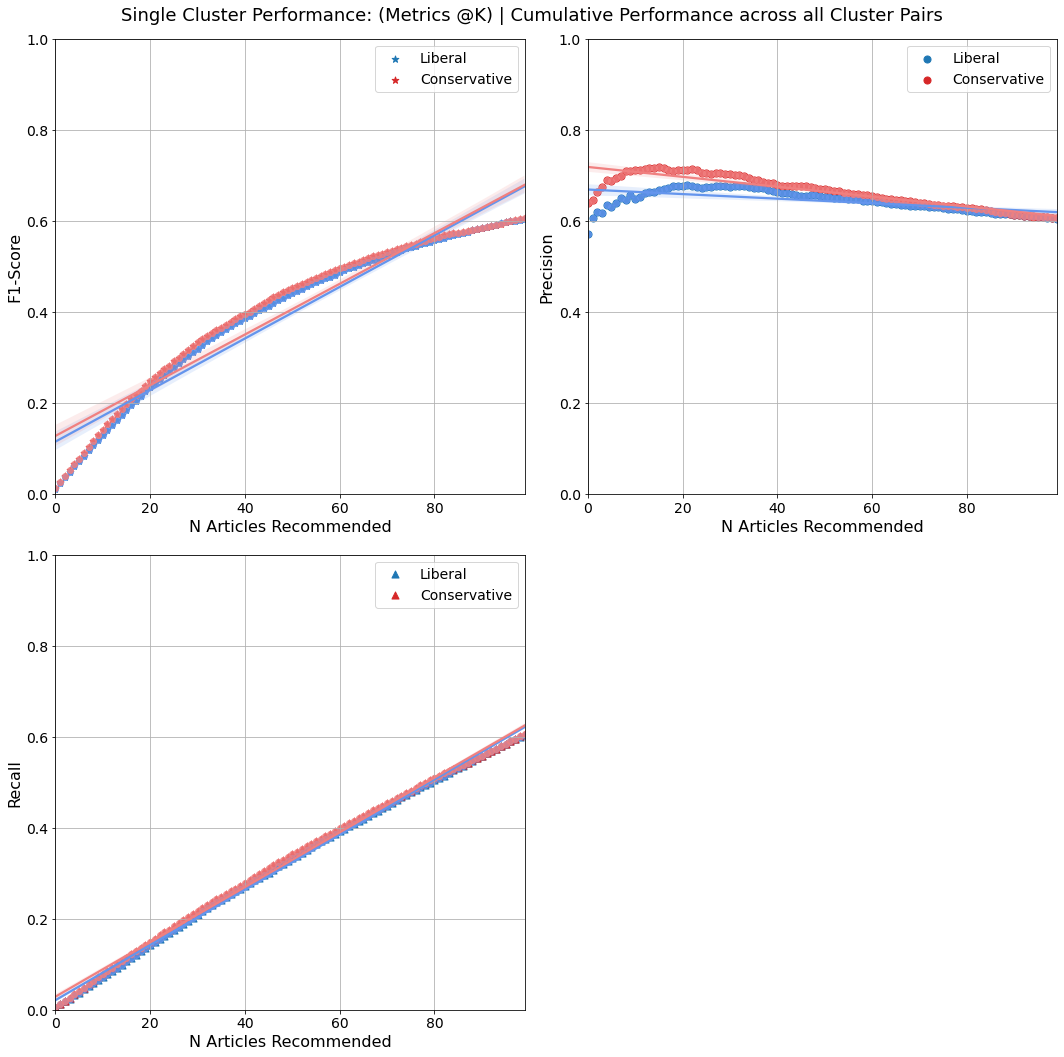


Finished running 'plot_single_cluster_performance' in 0.0170 mins


Finished running 'plot_single_cluster_cumulative' in 0.0171 mins



In [25]:
plot_single_cluster_cumulative(homo_scores,hetero_scores)

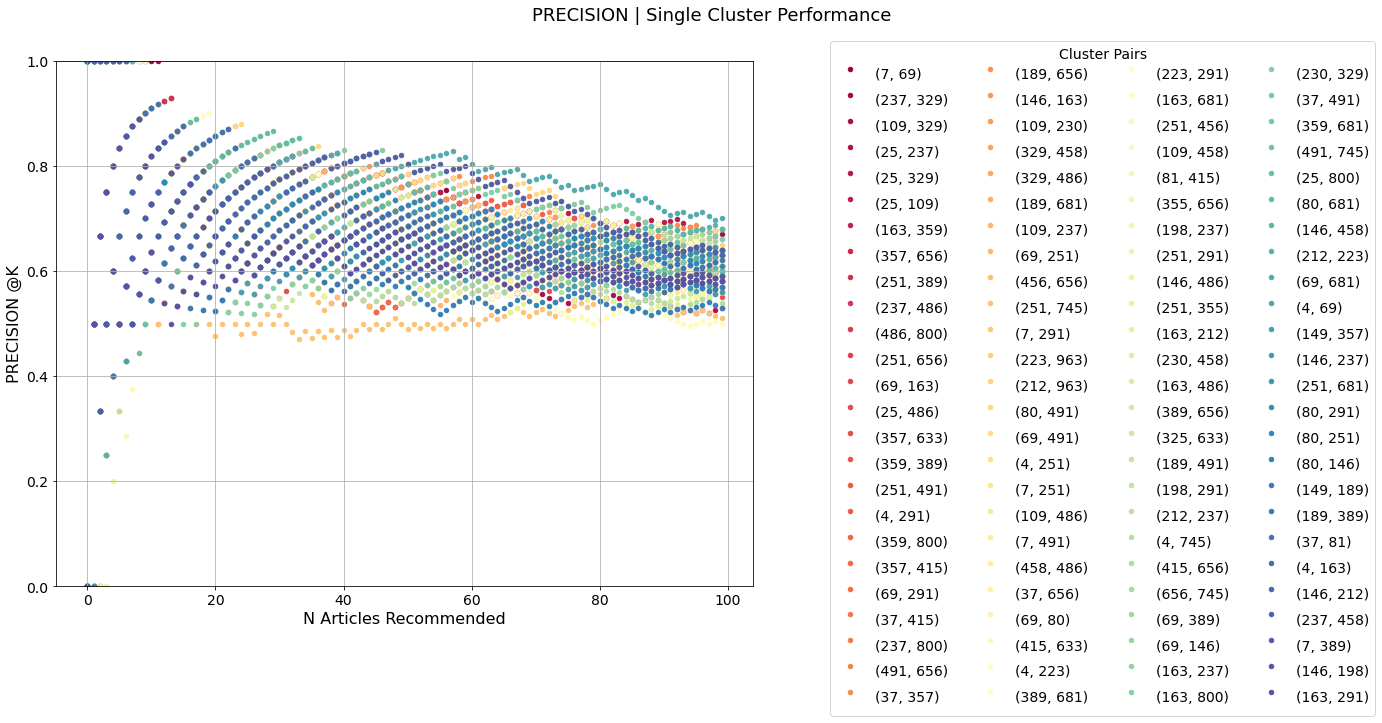


Finished running 'plot_all_cp_singlecluster' in 0.0579 mins



In [26]:
plot_all_cp_singlecluster(homo_scores)

In [27]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [28]:
np.mean(avg_presc_homo)

0.6644454693571117

## Baseline 4: <a class="anchor" id="Regularization_vs_Online_Setting_Performance"></a>

In [29]:
hetero_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [30]:
homo_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0004 mins



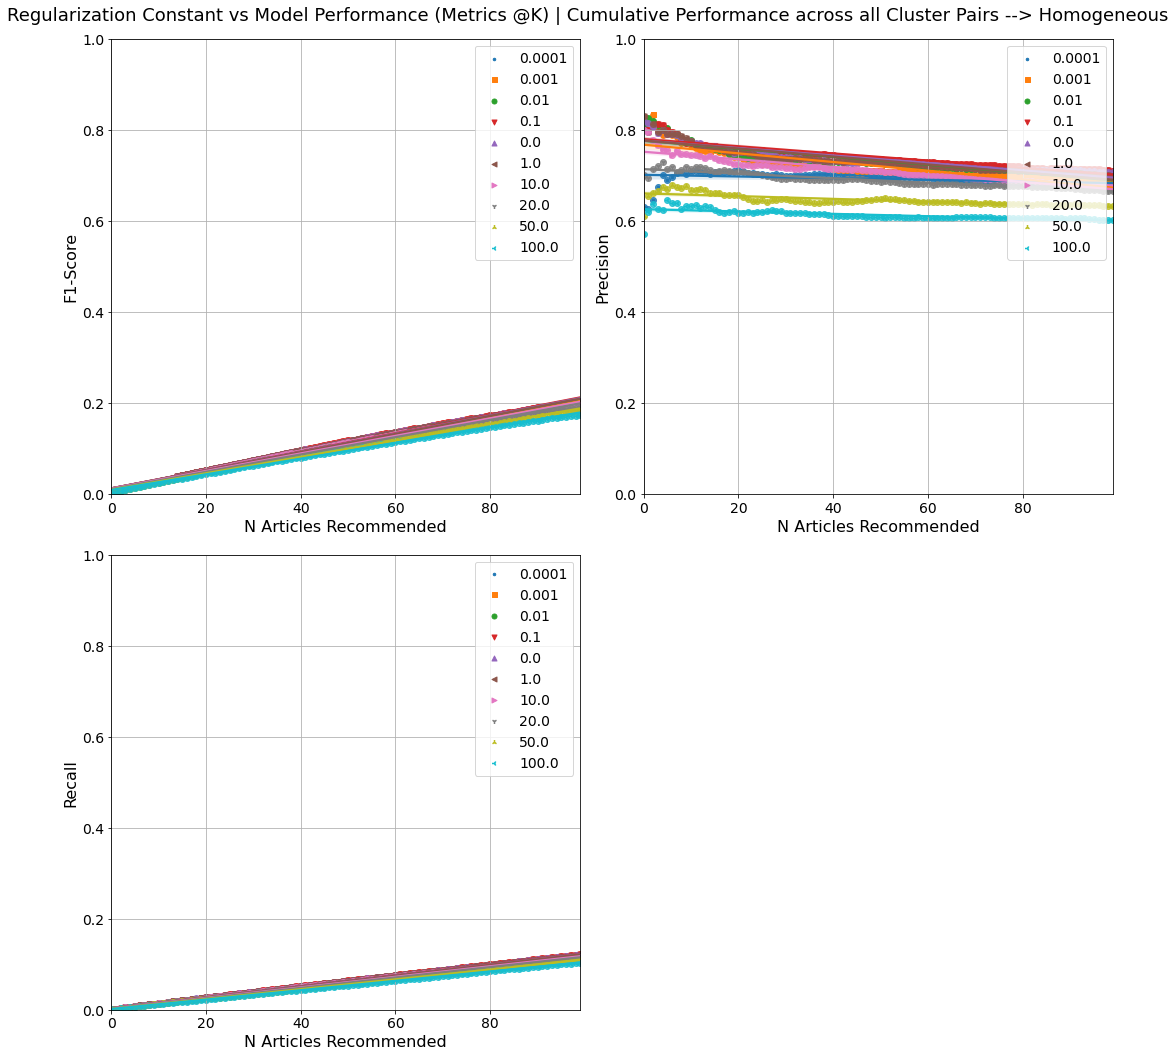


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0806 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0810 mins



In [31]:
plot_regularization_vs_metrics_at_k_cumu(homo_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0],
                                         user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0006 mins



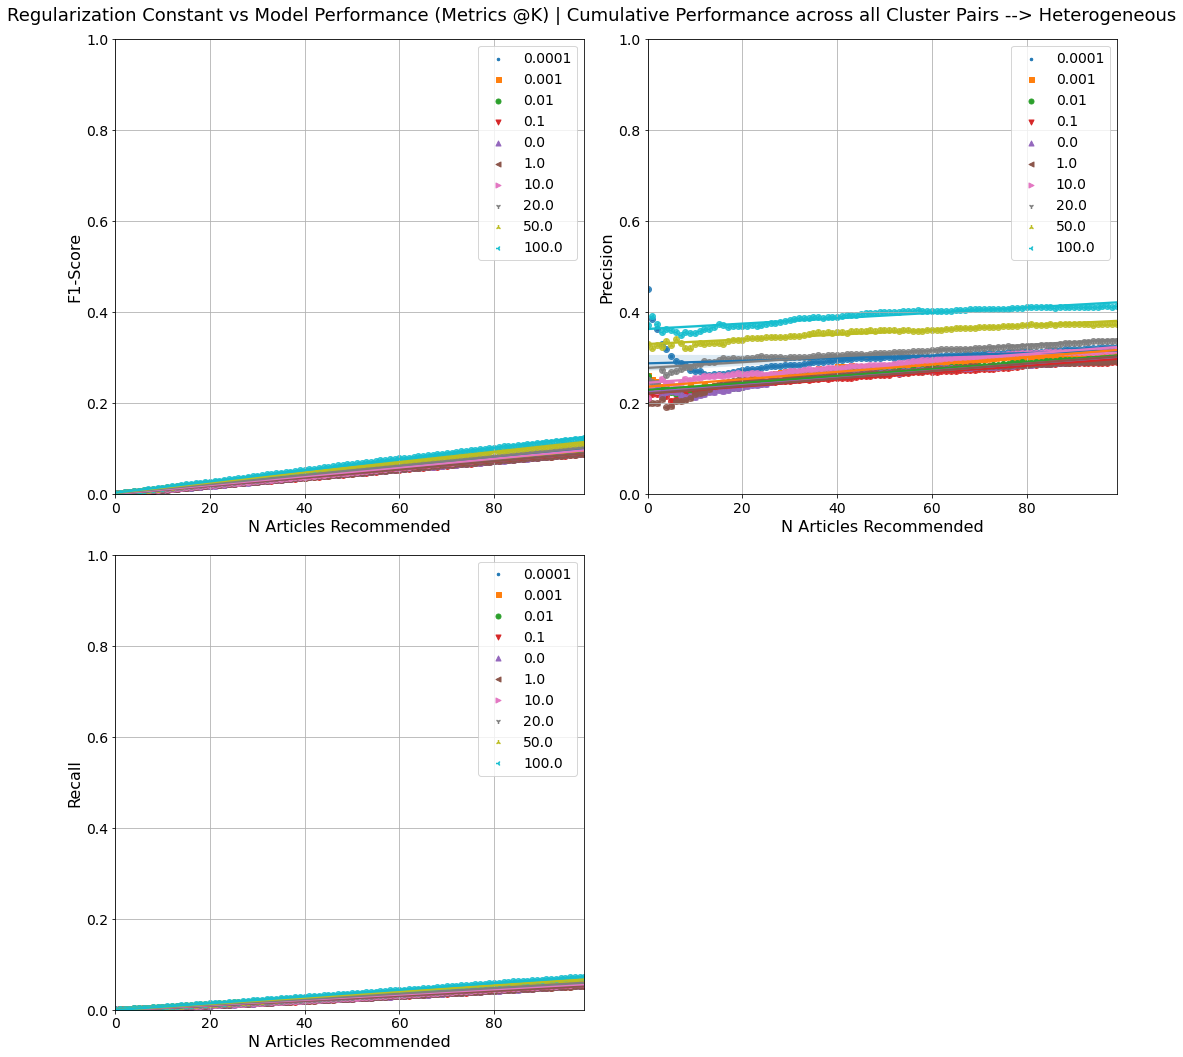


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0846 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0852 mins



In [32]:
plot_regularization_vs_metrics_at_k_cumu(hetero_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [33]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [34]:
calculate_map_param_variation(homo_param_res)


Param : 0.0001
0.6918673136467747

Param : 0.001
0.7200368745635956

Param : 0.01
0.7322380495705658

Param : 0.1
0.7404676799891728

Param : 0.0
0.7355889339250224

Param : 1.0
0.7328941201693797

Param : 10.0
0.7105102017211583

Param : 20.0
0.6887096845070269

Param : 50.0
0.6452401540117534

Param : 100.0
0.6127142368054836


In [35]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [36]:
calculate_map_param_variation(hetero_param_res)


Param : 0.0001
0.3008188627564517

Param : 0.001
0.2757567749392782

Param : 0.01
0.26629323060058047

Param : 0.1
0.2585088747182904

Param : 0.0
0.2621183838977844

Param : 1.0
0.26120611456909487

Param : 10.0
0.2834295537843209

Param : 20.0
0.30808238747128014

Param : 50.0
0.3546804926223994

Param : 100.0
0.3914653280329965


## Baseline 5 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Performance"></a>

In [37]:
hetero_scores,df_het_res_100,df_het_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (7, 69) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (7, 69) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (7, 69) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (7, 69) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (7, 69) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (7, 69) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (7, 69) , LR = 20 ****************
SGDClassi

In [38]:
homo_scores,df_hom_res_100,df_hom_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (7, 69) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (7, 69) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (7, 69) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (7, 69) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (7, 69) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (7, 69) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (7, 69) , LR = 20 ****************
SGDClassi


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0009 mins



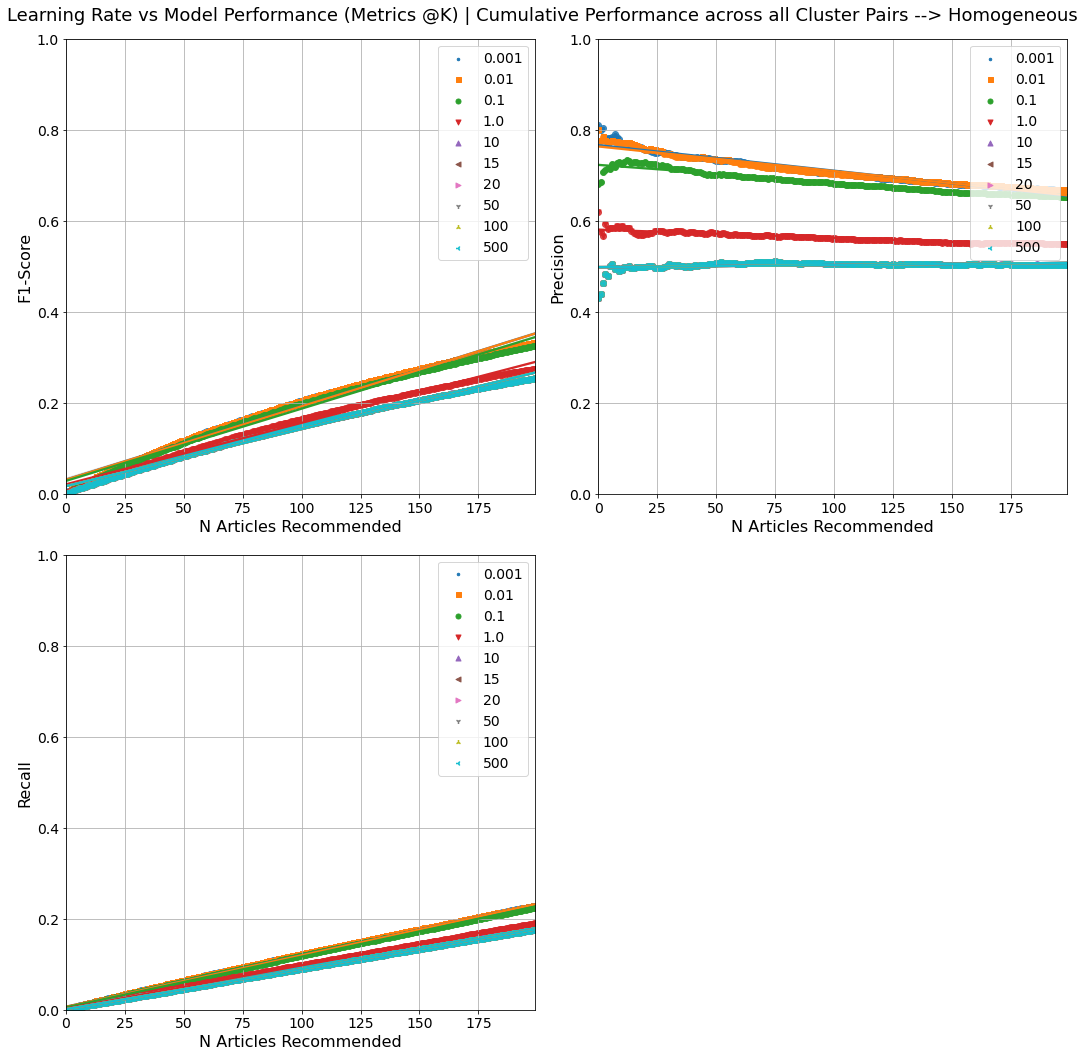


Finished running 'plot_lr_vs_metrics_at_k' in 0.0874 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0883 mins



In [39]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0007 mins



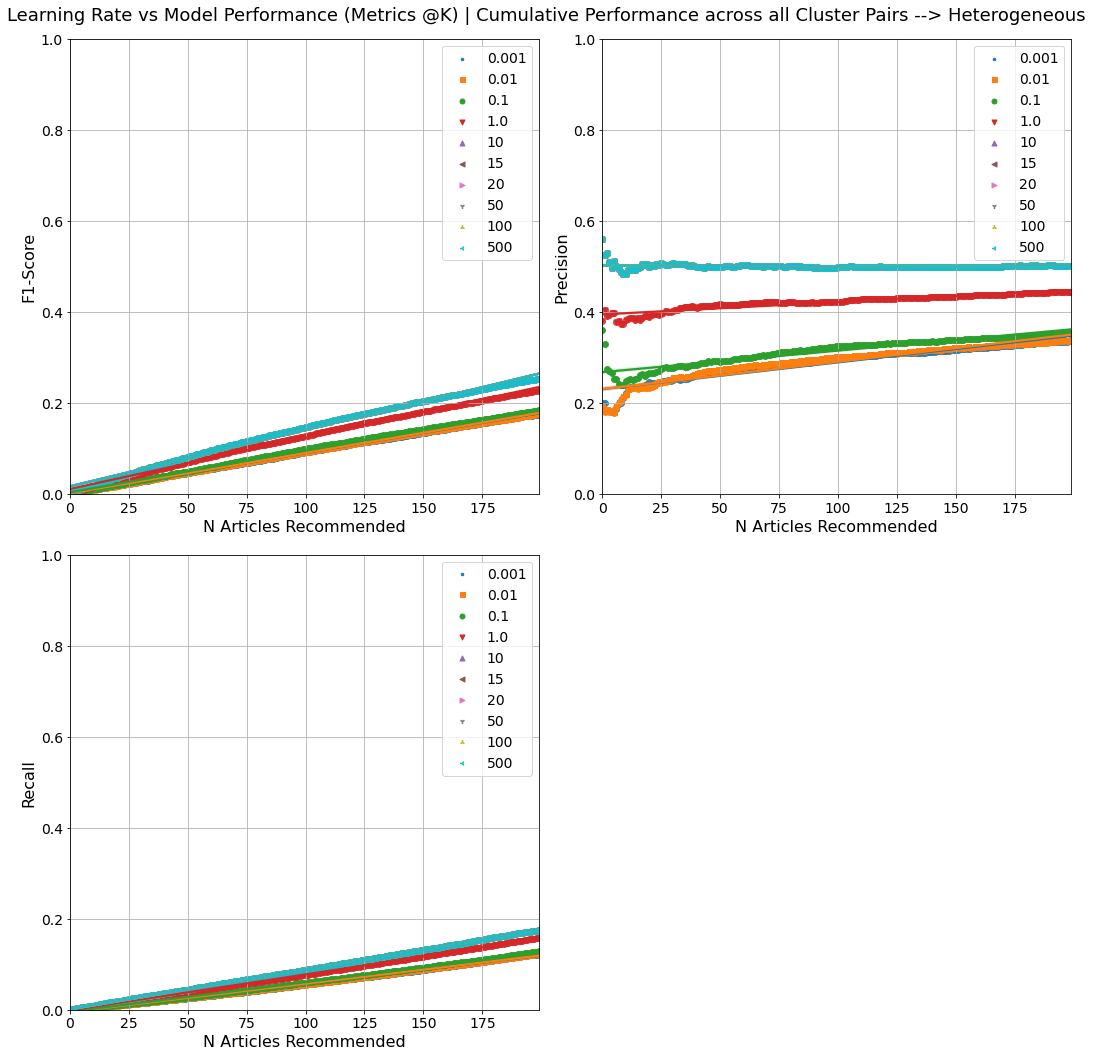


Finished running 'plot_lr_vs_metrics_at_k' in 0.0873 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0880 mins



In [40]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [41]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [42]:
calculate_map_param_variation(homo_param_res)


Param : 0.001
0.7103844824347203

Param : 0.01
0.7095323247454702

Param : 0.1
0.6846864292725166

Param : 1.0
0.5626522718303817

Param : 10
0.5027857947894069

Param : 15
0.5027637844344072

Param : 20
0.5027637844344072

Param : 50
0.5027637844344072

Param : 100
0.5027637844344072

Param : 500
0.5027637844344072


In [43]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [44]:
calculate_map_param_variation(hetero_param_res)


Param : 0.001
0.2886333619527088

Param : 0.01
0.2901891463661888

Param : 0.1
0.31444958567001224

Param : 1.0
0.4211840339576526

Param : 10
0.5001614940234956

Param : 15
0.5001614940234956

Param : 20
0.5001614940234956

Param : 50
0.5001614940234956

Param : 100
0.5001614940234956

Param : 500
0.5001614940234956


## Baseline 6: <a class="anchor" id="Online_Setting_Mixed_Data_Performance"></a>

In [45]:
hetero_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [46]:
homo_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [47]:
# homo_scores.keys()

In [48]:
# plot_mixed_data_performance_per_cluster(homo_scores[(585, 712)],hetero_scores[(585, 712)])


Finished running 'combine_scores_mixed_data' in 0.0002 mins


Finished running 'combine_scores_mixed_data' in 0.0002 mins



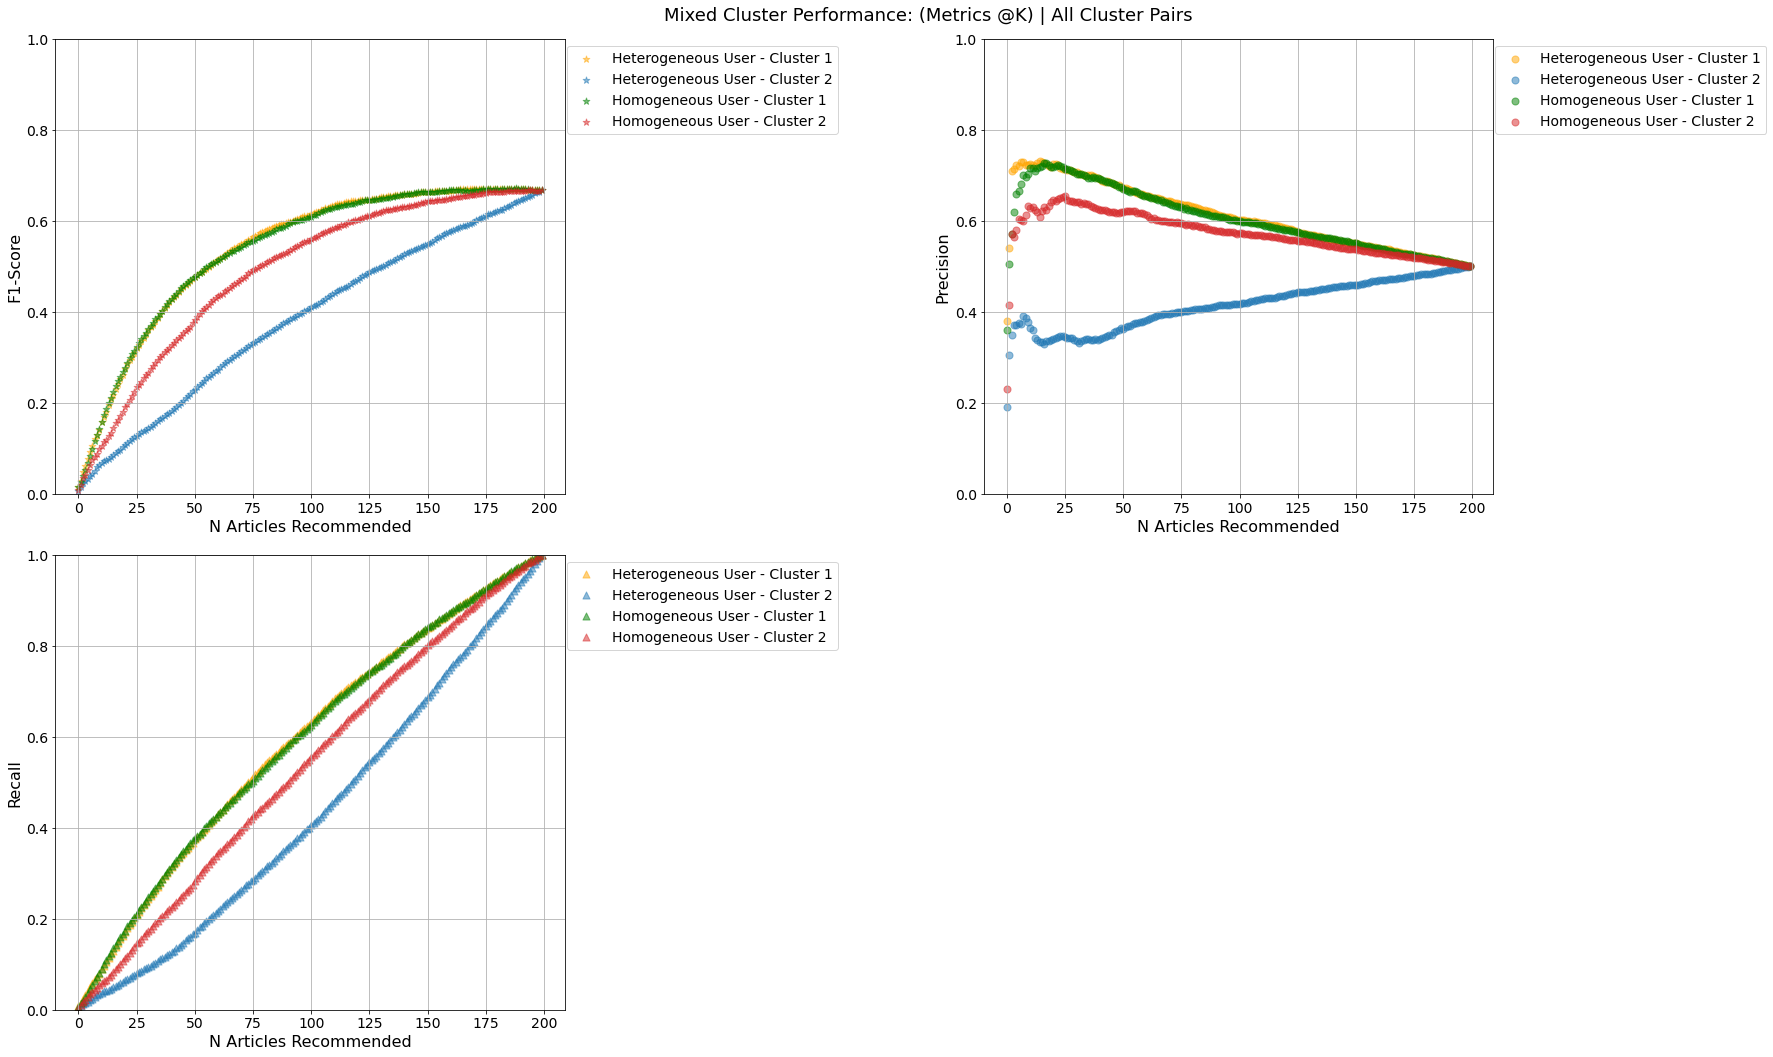


Finished running 'plot_mixed_data_performance_per_cluster' in 0.0109 mins


Finished running 'plot_mixed_cluster_cumulative_per_cluster' in 0.0113 mins



In [49]:
plot_mixed_cluster_cumulative_per_cluster(homo_scores,hetero_scores)

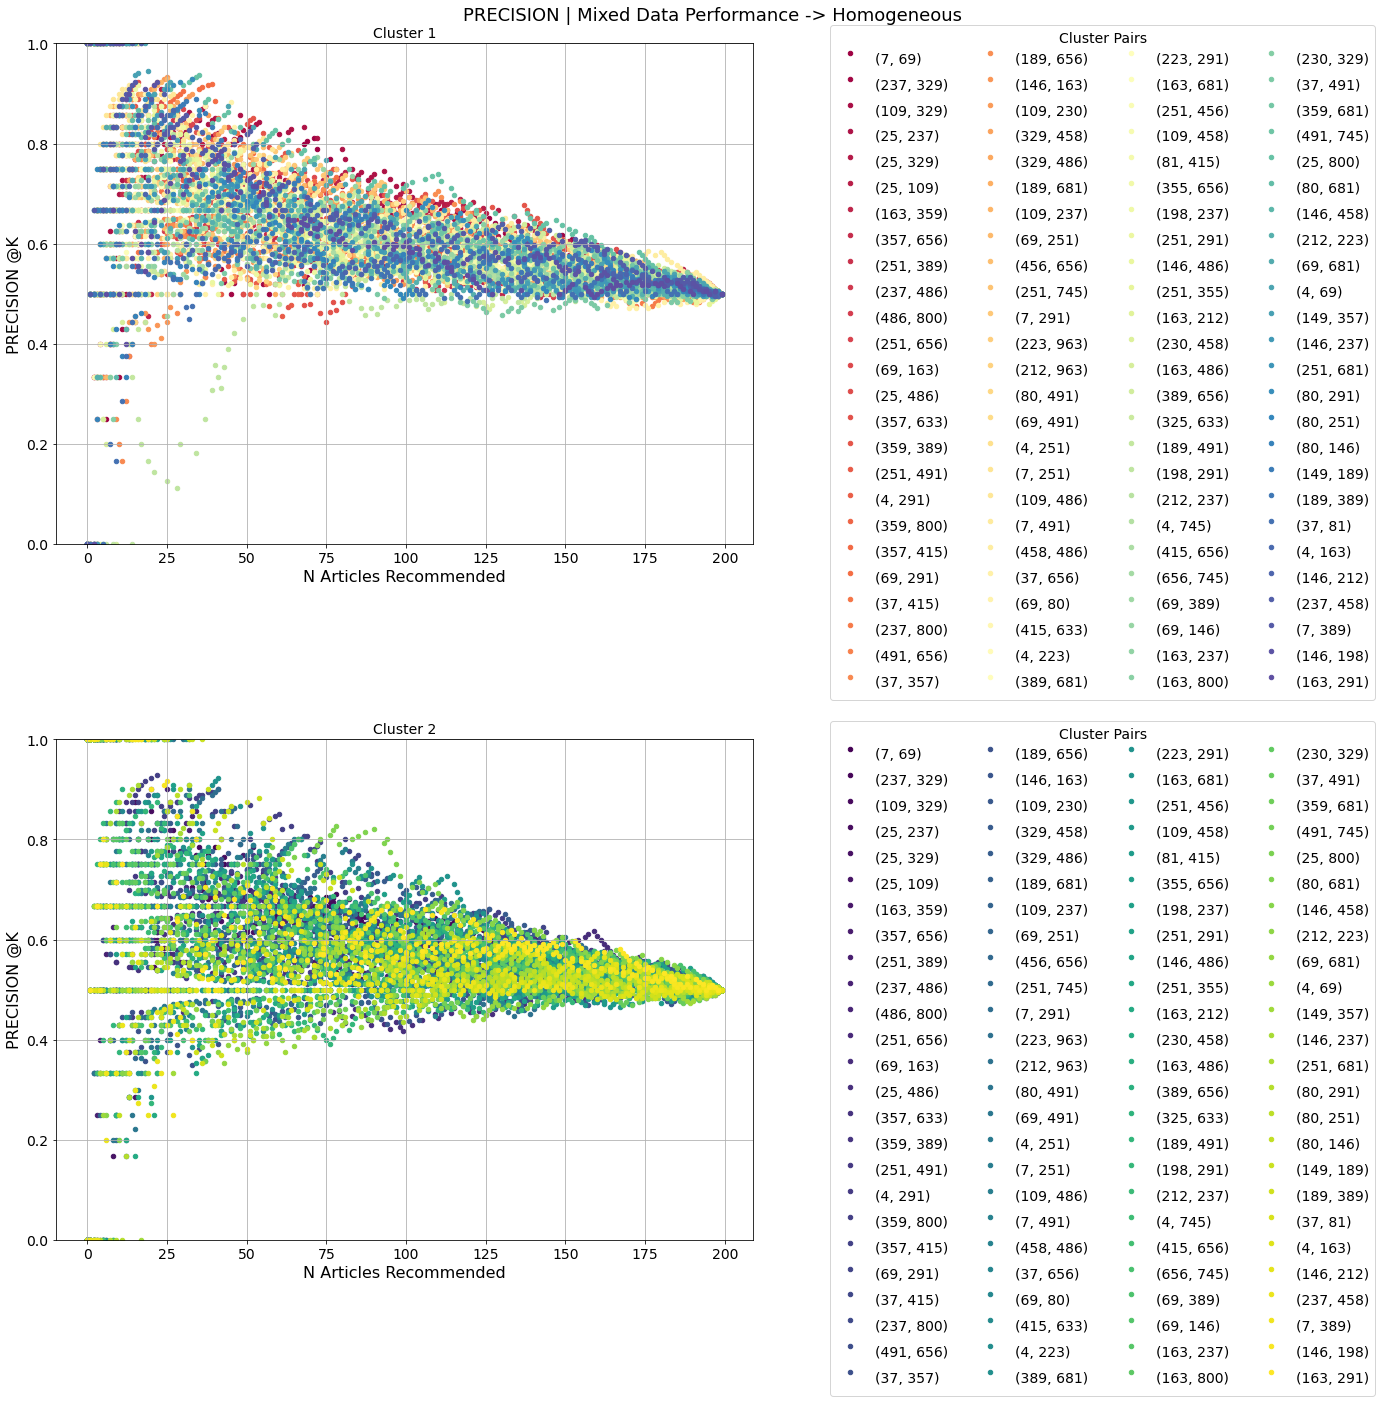


Finished running 'plot_mixed_data_all_cp_perf' in 0.1211 mins



In [50]:
plot_mixed_data_all_cp_perf(scores_cp=homo_scores,user_type="Homogeneous",metric="precision")

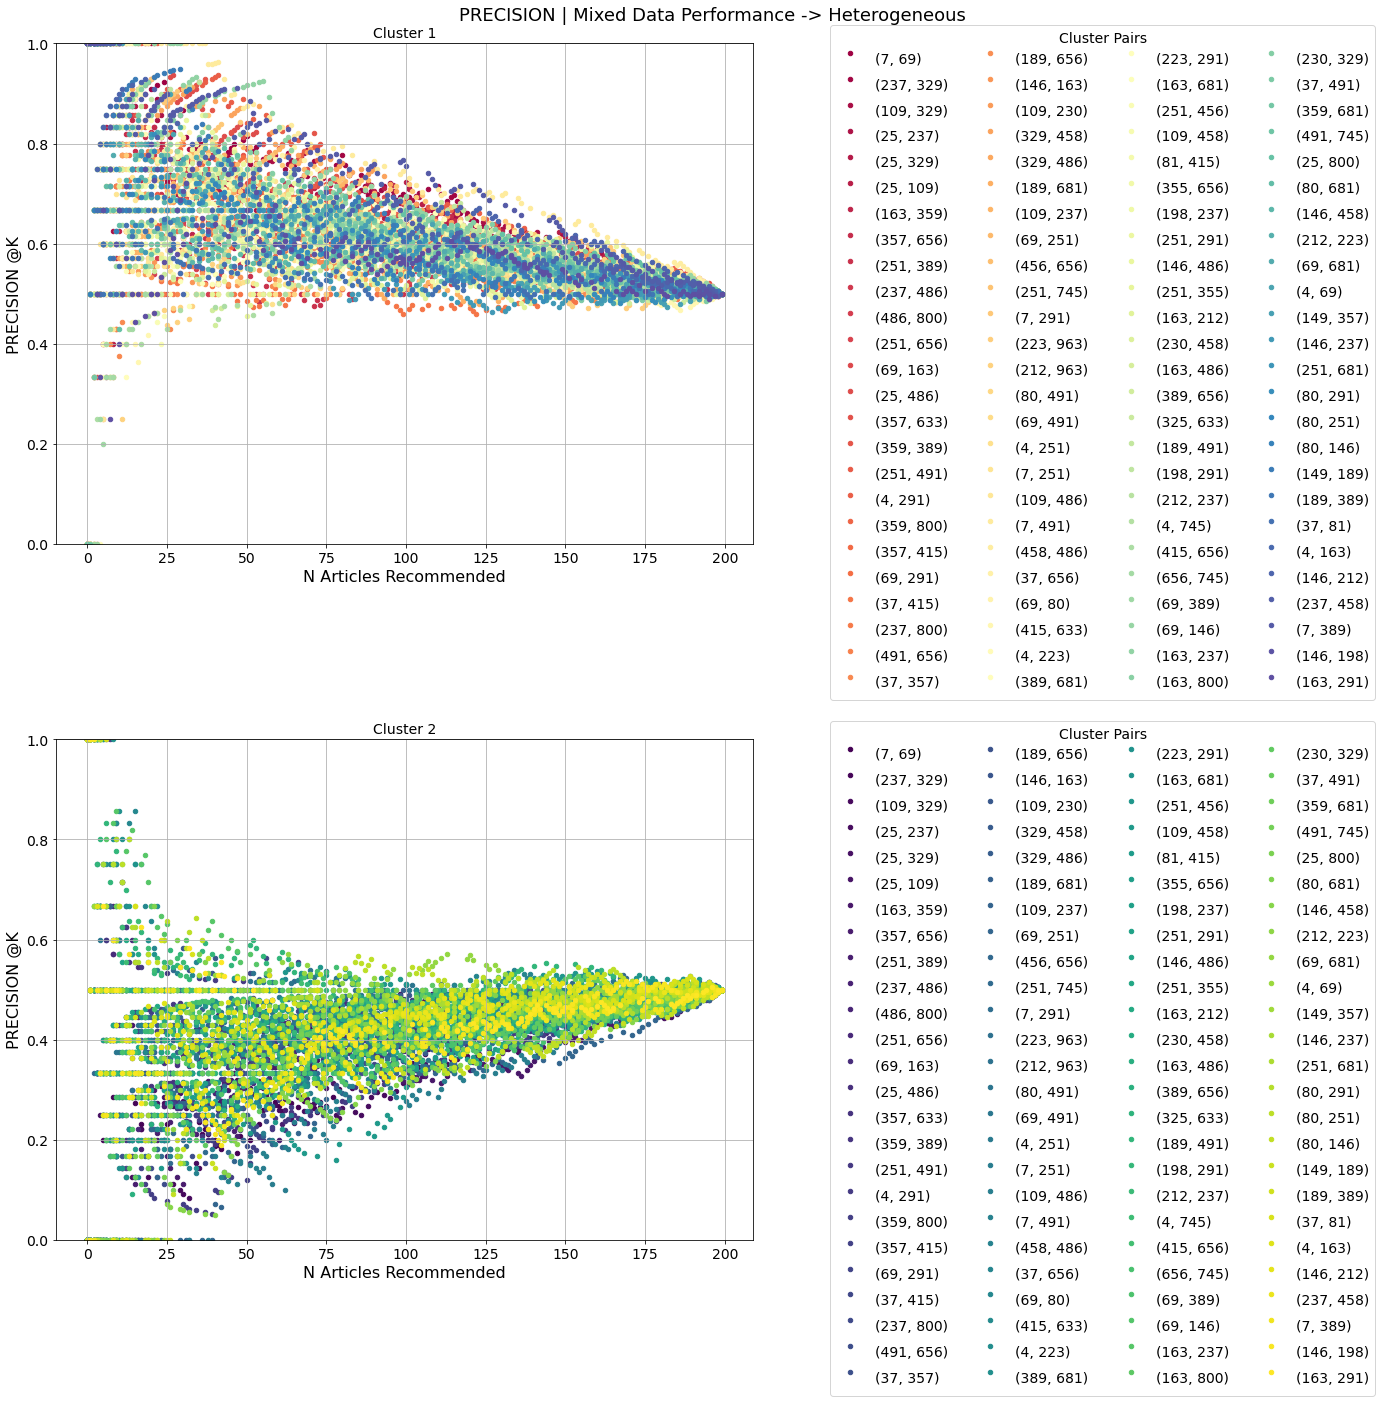


Finished running 'plot_mixed_data_all_cp_perf' in 0.1213 mins



In [51]:
plot_mixed_data_all_cp_perf(scores_cp=hetero_scores,user_type="Heterogeneous",metric="precision")

In [53]:
avg_presc_homo,avg_presc_homo_c1, avg_presc_homo_c2 = calculate_avg_precision(homo_scores,mode="mixed")

In [54]:
np.mean(avg_presc_homo)

0.5916201784173475

In [55]:
np.mean(avg_presc_homo_c1)

0.6045229460255376

In [56]:
np.mean(avg_presc_homo_c2)

0.5710265351511367

In [57]:
avg_presc_hetero,avg_presc_hetero_c1, avg_presc_hetero_c2 = calculate_avg_precision(hetero_scores,mode="mixed")

In [58]:
np.mean(avg_presc_hetero)

0.5231497208440321

In [59]:
np.mean(avg_presc_hetero_c1)

0.6094393722207284

In [60]:
np.mean(avg_presc_hetero_c2)

0.4152690533267894

## Baseline 7 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Mixed_Data_Performance"></a>

In [61]:
hetero_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [62]:
homo_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [63]:
# plot_lr_vs_metrics_at_k_mixed(homo_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],user_type="Homogeneous")

In [64]:
# plot_lr_vs_metrics_at_k_mixed(hetero_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0006 mins



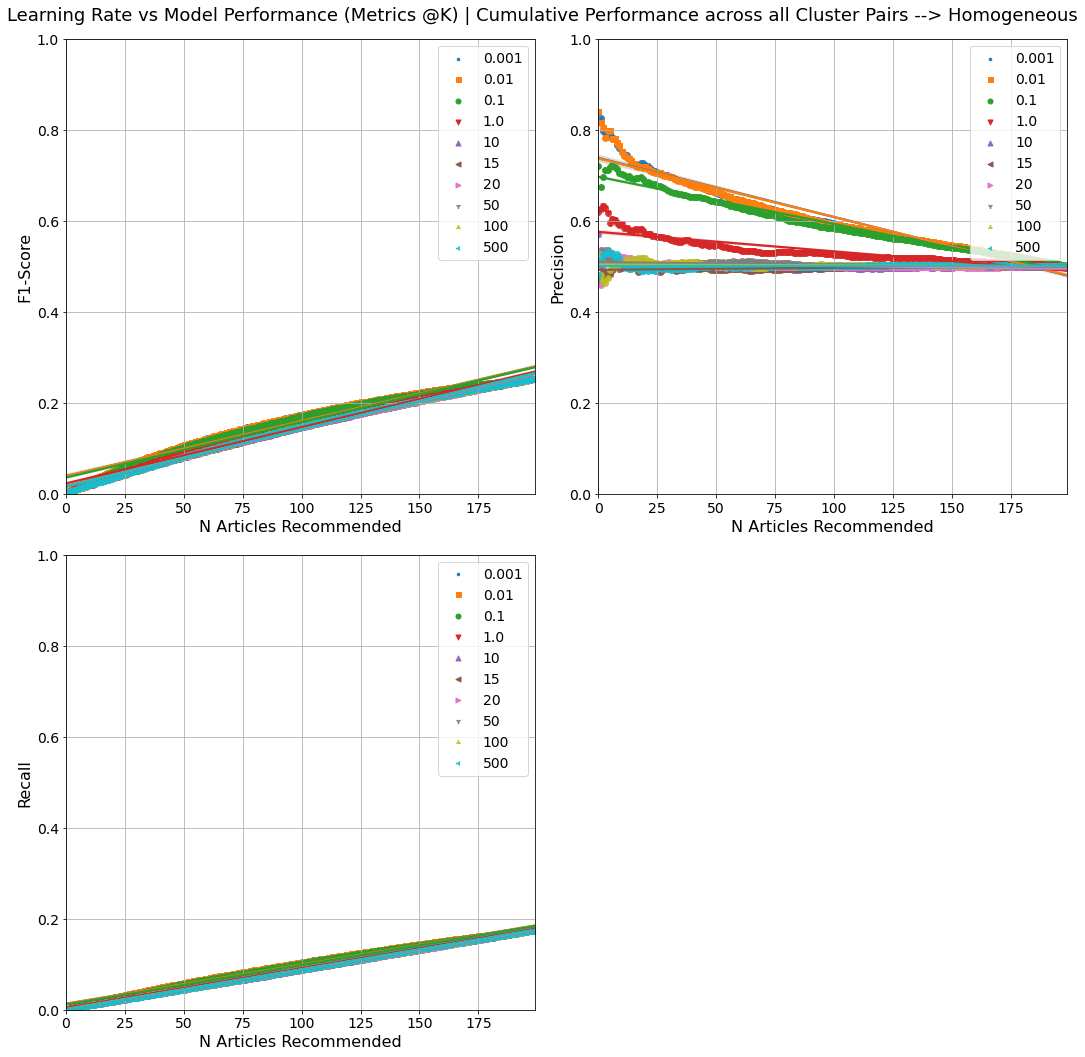


Finished running 'plot_lr_vs_metrics_at_k' in 0.0715 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0721 mins



In [65]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous",mixed_data=True)


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0006 mins



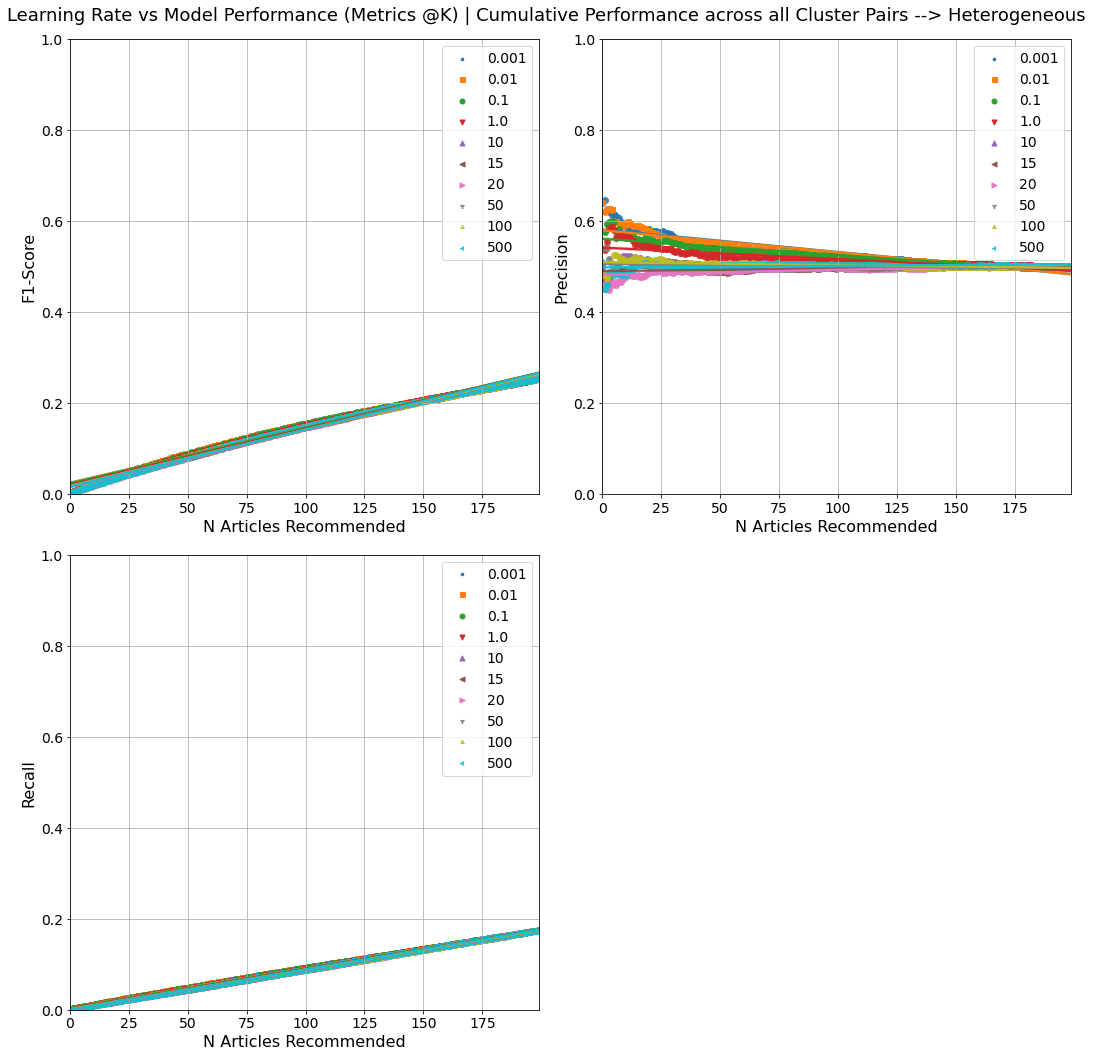


Finished running 'plot_lr_vs_metrics_at_k' in 0.0667 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0673 mins



In [66]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mixed_data=True)

In [67]:
#  plot_mixed_data_all_cp_precis_lr(scores_=homo_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Homogeneous",metric="precision")

In [68]:
#  plot_mixed_data_all_cp_precis_lr(scores_=hetero_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Heterogeneous",metric="precision")

In [69]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [70]:
calculate_map_param_variation(homo_param_res,mode="mixed")


Param : 0.001
0.6088798665925804
c1 MAP : 
0.6295167525272742
c2 MAP : 
0.5735718929955856

Param : 0.01
0.6087257040250706
c1 MAP : 
0.6299644815270754
c2 MAP : 
0.5728379110897432

Param : 0.1
0.593416215470494
c1 MAP : 
0.6133893023046422
c2 MAP : 
0.5620356212114163

Param : 1.0
0.5329979156181645
c1 MAP : 
0.5363231133042672
c2 MAP : 
0.5215556177678567

Param : 10
0.49930166093759676
c1 MAP : 
0.49677360038955676
c2 MAP : 
0.49422577451749083

Param : 15
0.4967143306063211
c1 MAP : 
0.49738603174676455
c2 MAP : 
0.49035403903958746

Param : 20
0.5007912742008807
c1 MAP : 
0.4955977468884237
c2 MAP : 
0.5020534732278524

Param : 50
0.5038508802178352
c1 MAP : 
0.5038782524151463
c2 MAP : 
0.49834895252295985

Param : 100
0.5020645241376113
c1 MAP : 
0.4986771356060434
c2 MAP : 
0.5008302513633329

Param : 500
0.5008213723330349
c1 MAP : 
0.4985417512466491
c2 MAP : 
0.4992804808061118


In [71]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [72]:
calculate_map_param_variation(hetero_param_res,mode="mixed")


Param : 0.001
0.5316568587967835
c1 MAP : 
0.6284828874958537
c2 MAP : 
0.4036836211781072

Param : 0.01
0.5310366687339899
c1 MAP : 
0.6253446917744417
c2 MAP : 
0.4048540905260562

Param : 0.1
0.5248978078634435
c1 MAP : 
0.6070538987355948
c2 MAP : 
0.4172384951697938

Param : 1.0
0.5158840827191016
c1 MAP : 
0.5435543926510937
c2 MAP : 
0.47762521823440274

Param : 10
0.5021183485359285
c1 MAP : 
0.4981991915409424
c2 MAP : 
0.4982036828084041

Param : 15
0.49497062867261116
c1 MAP : 
0.49278521836502276
c2 MAP : 
0.4916495135339002

Param : 20
0.49241354693447237
c1 MAP : 
0.4879625428258045
c2 MAP : 
0.49338577541702944

Param : 50
0.5005147621331795
c1 MAP : 
0.5021034201858171
c2 MAP : 
0.49449891455467865

Param : 100
0.5025639669388007
c1 MAP : 
0.49775282848399327
c2 MAP : 
0.5021930793307593

Param : 500
0.501203824554272
c1 MAP : 
0.5023317271438701
c2 MAP : 
0.4955922664572293
